In [311]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [312]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# **1. Problem Definition and Dataset Selection**

1) Untuk menentukan faktor yang berkaitan dengan tindak balas yang tidak efektif (ditakrifkan sebagai kelewatan dalam mencapai remisi) menggunakan metod SHAP.

2) Untuk menentukan faktor yang berkaitan dengan perkembangan kerosakan organ dan kematian dalam SLE menggunakan metod SHAP.

In [313]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

data = pd.read_excel("ANONYMOUS DATA EXCEL LN RELAPSE_UKM.xlsx")



In [314]:
data.head(5)


,NO,PATIENT ID,DOB,RACE,GENDER,YEAR DIAGNOSIS,MSK,MUCOCUTANEOS,HEMATO,NPSLE,...,AC KIDNEY INJURY INITIAL (AKI),APLS,DAMAGE SLICC 24 MTH,CKD,DAMAGE 24 MTH,ANY CR 6 MTH,CR 6 MTH PRED 10,CR 12 MTH PRED 10,CR 6 MTH PRED 7.5,CR 12 MTH PRED 7.5
0,1,1,1976,0,1,2005,1,0,0,0,...,0,0,0,0,"pULM HPT NOV 05, MENOPAUSE 09",1,1,1,0,1
1,2,2,1985,1,0,2003,0,1,1,1,...,1,0,1,1,2007-2008:SEIZURE- MRI BRAIN OLD LACUNAR INF...,1,1,1,0,1
2,3,3,1975,1,1,2004,0,1,1,0,...,0,0,0,0,"2006-SDM,cataract",1,0,1,0,1
3,4,4,1981,0,1,2005,1,1,0,0,...,0,0,0,0,NaN,0,0,0,0,0
4,5,4B,1981,0,1,2005,1,1,0,0,...,0,0,0,0,NaN,0,0,0,0,0


# 2. Data Preprocessing and Feature Engineering

**a. Drop irrelevant Features**

In [315]:
# Define preprocessing functions
def drop_columns(data):
    return data.drop(columns=[
        'NO',
        'LN',
        'CKD 24 MONTH',
        'ENA',
        'WHO CLASS',
        'RELAPSE WITHIN 12 MONTH',
        'RELAPSE WITHIN 24 MONTH',
        'INDUCTION TX',
        'MAINTAINENCE TX',
        'MMF_MAINTAINENCE',
        'RITUX',
        'TRIPLE TX',
        'INFECTION INPT',
        'DAMAGE 24 MTH',
        'DOB',
        'CREAT 24 MONTH',
        'YIME TO RELAPSE',
        'Unnamed: 53',
        'INDUCTION TX.1',
        'DATE OF BIOPSY',
        'RELAPSE EPISODE',
        'DAMAGE SLICC 24 MTH',
        'UPCI 24MTH',
        'UPCI 18 MTH',
        'UPCI 3 MTH',
        'UPCI 6 MTH',
        'UPCI 12 MTH',
        'ANY CR 6 MTH',
        'CR 6 MTH PRED 10',
        'CR 6 MTH PRED 7.5',
        'CR 12 MTH PRED 7.5'
    ])

**b. Feature Splitting**

In [316]:
def get_feature_columns():
    # Numerical Features
    numeric_columns = [
        'YEAR DIAGNOSIS', 'CREAT BASELINE', 'ALBUMIN BASELINE',
        'C3 PRE TX', 'C4 PRETX', 'YEAR ACTIVE LN', 'AGE AT INDUCTION TX',
        'CRESCENT', 'GLOBAL SCLEROSIS', 'CHRONIC INDEX', 'ACTIVE INDEX', 'MONTH INTERVAL TO INDUCTION TX',
        'UPCI PRE TX', 'CR 12 MTH PRED 10'
    ]

    # Categorical Features
    categorical_columns = [
        'PATIENT ID','RACE', 'GENDER', 'MSK', 'MUCOCUTANEOS', 'HEMATO', 'NPSLE', 'CVS', 'PULM', 'SEROSITIS',
        'GIT', 'ANTIDSDNA PRE TX', 'ANA', 'PATTERN', 'ACL IGG',
        'ACL IGM', 'LA', 'ANTIB2 GP1 IGG', 'ANTIB2GP1 IGM', 'APL POSITIVE', 'HPT BASELINE',
        'RB_diffuse', 'CLASS 3 OR 4', 'INDUCTION CYC',
        'FIRST OR RELAPSE LN', 'HCQ',
        'ACE/ARB', 'AC KIDNEY INJURY INITIAL (AKI)', 'APLS', 'CKD',

    ]

    return numeric_columns, categorical_columns


**d. Missing Value Imputation**

In [317]:
def impute_missing_values(df, numeric_columns, categorical_columns):
    df = df.copy()

    # === FLAG MISSINGNESS FOR SELECT FEATURES ===
    flag_cols = ['CRESCENT', 'GLOBAL SCLEROSIS', 'CHRONIC INDEX', 'ACTIVE INDEX']
    for col in flag_cols:
        if col in df.columns:
            df[f"{col}_MISSING"] = df[col].isnull().astype(int)

    # === NUMERICAL IMPUTATION ===
    for col in numeric_columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())

    # === CATEGORICAL IMPUTATION ===
    categorical_impute_map = {
        'ANTIDSDNA PRE TX': 2,
        'ANA': df['ANA'].mode()[0],
        'PATTERN': 0,
        'ACL IGG': 2,
        'ACL IGM': 2,
        'LA': 2,
        'ANTIB2 GP1 IGG': 2,
        'ANTIB2GP1 IGM': 2,
        'APL POSITIVE': 2
    }

    # Features safe to cast to int (known categorical numeric)
    safe_int_cast_cols = [
        'ACL IGG', 'ACL IGM', 'LA',
        'ANTIB2 GP1 IGG', 'ANTIB2GP1 IGM', 'APL POSITIVE'
    ]

    for col, val in categorical_impute_map.items():
        if col in df.columns:
            df[col] = df[col].fillna(val)
            if col in safe_int_cast_cols:
                df[col] = df[col].astype(int)


    return df


checking imputations

In [318]:
# === Step 1: Drop irrelevant columns ===
data_cleaned = drop_columns(data)

# === Step 2: Get numeric and categorical columns ===
numeric_cols, categorical_cols = get_feature_columns()

# === Step 3: Apply imputation ===
data_imputed = impute_missing_values(data_cleaned, numeric_cols, categorical_cols)

# === Step 4: Check imputation results for specific features ===
# You can change these to any features you want to check
features_to_check = ['ANTIDSDNA PRE TX', 'ANA', 'PATTERN', 'CRESCENT', 'CRESCENT_MISSING', 'GLOBAL SCLEROSIS', 'GLOBAL SCLEROSIS_MISSING']

# Display rows with originally missing values (now filled)
data_imputed[features_to_check].head(219)


,ANTIDSDNA PRE TX,ANA,PATTERN,CRESCENT,CRESCENT_MISSING,GLOBAL SCLEROSIS,GLOBAL SCLEROSIS_MISSING
0,0.0,640.0,S,0.0,0,0.0,0
1,1.0,640.0,S,5.0,0,0.0,0
2,1.0,1280.0,H,2.5,0,0.0,0
3,0.0,160.0,S,5.0,0,0.0,0
4,0.0,80.0,S,0.0,0,0.0,0
...,...,...,...,...,...,...,...
213,1.0,640.0,S,0.0,0,54.0,0
214,2.0,320.0,S,2.0,0,0.0,0
215,1.0,640.0,S,0.0,0,35.0,0
216,1.0,80.0,S,9.0,0,28.0,0


d. Outlier Handling (Data Transformation)

In [319]:
import numpy as np

def log_transform_features(df, features):
    df = df.copy()
    for col in features:
        if col in df.columns:
            # Shift if needed to avoid log(0)
            min_val = df[col].min()
            if min_val <= 0:
                shift = abs(min_val) + 1e-6
                df[col] = np.log(df[col] + shift)
            else:
                df[col] = np.log(df[col])
    return df


In [320]:
log_features = [
    'C3 PRE TX', 'C4 PRETX',
    'UPCI PRE TX'
]

data_log_transformed = log_transform_features(data_imputed, log_features)


**e. Feature Engineering**

- Onset of LN from SLE Diagnosis = YEAR ACTIVE LN - YEAR DIAGNOSIS

In [321]:
def feature_engineering(df):
    df = df.copy()

    # Create derived feature
    if 'YEAR ACTIVE LN' in df.columns and 'YEAR DIAGNOSIS' in df.columns:
        df['ONSET_LN_FROM_DIAGNOSIS'] = df['YEAR ACTIVE LN'] - df['YEAR DIAGNOSIS']
        # Drop the original columns
        df = df.drop(columns=['YEAR ACTIVE LN', 'YEAR DIAGNOSIS'])

    return df


**f. Encoding**

- label encoding for binary categorical features
- 1-hot encoding for low-cardinality features

In [322]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(df, categorical_columns):
    df = df.copy()
    encoded_df = df.copy()
    label_encoders = {}
    one_hot_columns = []

    # Step 1: Handle known categorical columns (binary or low-cardinality)
    for col in categorical_columns:
        if col in df.columns:
            unique_vals = df[col].nunique()

            if unique_vals == 2:
                # Label encode binary columns
                le = LabelEncoder()
                encoded_df[col] = le.fit_transform(df[col])
                label_encoders[col] = le
            elif unique_vals <= 5:
                # Flag for one-hot encoding
                one_hot_columns.append(col)

    # Step 2: One-hot encode multiclass features
    if one_hot_columns:
        encoded_df = pd.get_dummies(encoded_df, columns=one_hot_columns, drop_first=True)

    # Step 3: Label encode any leftover object columns not in categorical_columns
    for col in encoded_df.select_dtypes(include='object').columns:
        le = LabelEncoder()
        encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
        label_encoders[col] = le

    return encoded_df, label_encoders


**g. Scaling**

In [323]:
from sklearn.preprocessing import MinMaxScaler

def scale_numerical_features(df, numeric_columns):
    df = df.copy()
    scaler = MinMaxScaler()

    for col in numeric_columns:
        if col in df.columns:
            reshaped = df[[col]]
            df[col] = scaler.fit_transform(reshaped)

    return df, scaler


**H. Implement Stratified Split**

In [324]:
from sklearn.model_selection import train_test_split

def perform_stratified_split(df, target_column, test_size=0.2, random_state=42):
    df = df.copy()

    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    return X_train, X_test, y_train, y_test


**I. Implement pipeline**

**cell 1: pipeline for catboost**

In [325]:
# === 1. Drop Irrelevant Columns ===
data_cleaned = drop_columns(data)

# === 2. Get Feature Columns ===
numeric_cols, categorical_cols = get_feature_columns()

# === 3. Impute Missing Values ===
data_imputed = impute_missing_values(data_cleaned, numeric_cols, categorical_cols)

# === 4. Apply Log Transformation (UPCI only for CatBoost)
log_features = [
    'UPCI PRE TX'
]
data_log_transformed = log_transform_features(data_imputed, log_features)

# === 5. Feature Engineering ===
data_engineered = feature_engineering(data_log_transformed)

# === 6a. Stratified Split for CatBoost - CKD objective ===
X_cb_ckd, X_cb_ckd_test, y_cb_ckd, y_cb_ckd_test = perform_stratified_split(
    data_engineered,
    target_column='CKD'
)

# === 6b. Stratified Split for CatBoost - Delayed Remission objective ===
X_cb_remission, X_cb_remission_test, y_cb_remission, y_cb_remission_test = perform_stratified_split(
    data_engineered,
    target_column='CR 12 MTH PRED 10'
)

# Step 7: Only include columns that are categorical
cat_features_cb = [
    col for col in categorical_cols
    if col in data_engineered.columns and data_engineered[col].dtype == 'object'
]

**cell 2: pipeline for non catboost**

In [326]:
# === 1. Drop Irrelevant Columns ===
data_cleaned = drop_columns(data)

# === 2. Get Feature Columns ===
numeric_cols, categorical_cols = get_feature_columns()

# === 3. Impute Missing Values ===
data_imputed = impute_missing_values(data_cleaned, numeric_cols, categorical_cols)

# === 4. Log Transformation ===
log_features = [
    'C3 PRE TX', 'C4 PRETX',
    'UPCI PRE TX'
]
data_log_transformed = log_transform_features(data_imputed, log_features)

# === 5. Feature Engineering ===
data_engineered = feature_engineering(data_log_transformed)

# === 6. Encoding (Label + One-Hot) ===
data_encoded, encoders = encode_categorical_features(data_engineered, categorical_cols)

# === 7. Scaling ===
data_scaled, scaler = scale_numerical_features(data_encoded, numeric_cols)

# === 8a. Stratified Split for CKD objective ===
X_ckd, X_ckd_test, y_ckd, y_ckd_test = perform_stratified_split(
    data_scaled,
    target_column='CKD'
)

# === 8b. Stratified Split for Delayed Remission objective ===
X_remission, X_remission_test, y_remission, y_remission_test = perform_stratified_split(
    data_scaled,
    target_column='CR 12 MTH PRED 10'
)


**J. SMOTE**

In [327]:
from imblearn.over_sampling import SMOTE

def apply_smote2(X, y, random_state=42):
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# === Apply SMOTE to CKD training set only
X_ckd_smote, y_ckd_smote = apply_smote2(X_ckd, y_ckd)

# Check class distribution
from collections import Counter
print("Before SMOTE:", Counter(y_ckd))
print("After SMOTE:", Counter(y_ckd_smote))


Before SMOTE: Counter({0: 125, 1: 49})
After SMOTE: Counter({0: 125, 1: 125})


 **K. Feature Extraction using RFE**

In [328]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

def apply_rfe(X, y, n_features_to_select=20):
    estimator = LogisticRegression(solver='liblinear', max_iter=1000)
    selector = RFE(estimator, n_features_to_select=n_features_to_select)
    selector.fit(X, y)

    # Keep selected features
    selected_features = X.columns[selector.support_]
    X_selected = X[selected_features]

    return X_selected, selector, selected_features


i) RFE - CKD

In [329]:
X_ckd_rfe, rfe_ckd, selected_features_ckd = apply_rfe(
    X_ckd_smote.drop(columns=["CR 12 MTH PRED 10"]),
    y_ckd_smote
)


print("Selected Features for CKD:")
print(selected_features_ckd)

Selected Features for CKD:
Index(['GENDER', 'MSK', 'MUCOCUTANEOS', 'NPSLE', 'SEROSITIS', 'CREAT BASELINE',
       'ALBUMIN BASELINE', 'C4 PRETX', 'CRESCENT', 'CHRONIC INDEX',
       'ACTIVE INDEX', 'ACE/ARB', 'AC KIDNEY INJURY INITIAL (AKI)',
       'GLOBAL SCLEROSIS_MISSING', 'RACE_1', 'ANTIDSDNA PRE TX_2.0', 'LA_1',
       'ANTIB2 GP1 IGG_2', 'APL POSITIVE_1', 'APL POSITIVE_2'],
      dtype='object')


In [330]:
selected_features_ckd_cb = [
    'GENDER',
    'MSK',
    'MUCOCUTANEOS',
    'NPSLE',
    'SEROSITIS',
    'CREAT BASELINE',
    'ALBUMIN BASELINE',
    'C4 PRETX',
    'CRESCENT',
    'CHRONIC INDEX',
    'ACTIVE INDEX',
    'ACE/ARB',
    'AC KIDNEY INJURY INITIAL (AKI)',
    'GLOBAL SCLEROSIS_MISSING',
    'RACE',
    'ANTIDSDNA PRE TX',
    'LA',
    'ANTIB2 GP1 IGG',
    'APL POSITIVE'
]


X_cb_ckd_rfe = X_cb_ckd[selected_features_ckd_cb].copy()
X_cb_ckd_test_rfe = X_cb_ckd_test[selected_features_ckd_cb].copy()
cat_features_cb_ckd_rfe = [col for col in cat_features_cb if col in selected_features_ckd_cb]


In [331]:
# ✅ Automatically detect categorical features based on dtype (int assumed categorical)
cat_cols = [
    col for col in X_cb_ckd_rfe.columns
    if X_cb_ckd_rfe[col].dtype in ['int64', 'int32']
]

print("Auto-detected categorical columns:", cat_cols)

# ✅ Cast them to category dtype for CatBoost native handling
for col in cat_cols:
    X_cb_ckd_rfe[col] = X_cb_ckd_rfe[col].astype('category')
    X_cb_ckd_test_rfe[col] = X_cb_ckd_test_rfe[col].astype('category')

# ✅ Build index list for CatBoost's cat_features parameter
cat_features_cb_ckd_rfe = [
    X_cb_ckd_rfe.columns.get_loc(col) for col in cat_cols
]

print("Categorical feature indices:", cat_features_cb_ckd_rfe)


Auto-detected categorical columns: ['GENDER', 'MSK', 'MUCOCUTANEOS', 'NPSLE', 'SEROSITIS', 'ACE/ARB', 'AC KIDNEY INJURY INITIAL (AKI)', 'GLOBAL SCLEROSIS_MISSING', 'RACE', 'LA', 'ANTIB2 GP1 IGG', 'APL POSITIVE']
Categorical feature indices: [0, 1, 2, 3, 4, 11, 12, 13, 14, 16, 17, 18]


In [332]:
print(X_cb_ckd_rfe.dtypes)

GENDER                            category
MSK                               category
MUCOCUTANEOS                      category
NPSLE                             category
SEROSITIS                         category
CREAT BASELINE                     float64
ALBUMIN BASELINE                   float64
C4 PRETX                           float64
CRESCENT                           float64
CHRONIC INDEX                      float64
ACTIVE INDEX                       float64
ACE/ARB                           category
AC KIDNEY INJURY INITIAL (AKI)    category
GLOBAL SCLEROSIS_MISSING          category
RACE                              category
ANTIDSDNA PRE TX                   float64
LA                                category
ANTIB2 GP1 IGG                    category
APL POSITIVE                      category
dtype: object


ii) RFE - CR 12 MTH PRED 10

In [333]:
# === Apply RFE to Delayed Remission Target (no SMOTE needed)
X_remission_rfe, rfe_remission, selected_features_remission = apply_rfe(
    X_remission, y_remission,
    n_features_to_select=20
)

print("Selected Features for Delayed Remission:")
print(selected_features_remission)


Selected Features for Delayed Remission:
Index(['PULM', 'GIT', 'ALBUMIN BASELINE', 'CRESCENT', 'GLOBAL SCLEROSIS',
       'ACTIVE INDEX', 'MONTH INTERVAL TO INDUCTION TX', 'FIRST OR RELAPSE LN',
       'INDUCTION CYC', 'ACE/ARB', 'UPCI PRE TX',
       'AC KIDNEY INJURY INITIAL (AKI)', 'CKD', 'CRESCENT_MISSING',
       'GLOBAL SCLEROSIS_MISSING', 'RACE_1', 'ANTIDSDNA PRE TX_1.0',
       'ACL IGM_1', 'LA_1', 'ANTIB2GP1 IGM_1'],
      dtype='object')


In [334]:
selected_features_remission = [
    'PULM',
    'GIT',
    'ALBUMIN BASELINE',
    'CRESCENT',
    'GLOBAL SCLEROSIS',
    'ACTIVE INDEX',
    'MONTH INTERVAL TO INDUCTION TX',
    'FIRST OR RELAPSE LN',
    'INDUCTION CYC',
    'ACE/ARB',
    'UPCI PRE TX',
    'AC KIDNEY INJURY INITIAL (AKI)',
    'CKD',
    'CRESCENT_MISSING',
    'GLOBAL SCLEROSIS_MISSING',
    'RACE',
    'ANTIDSDNA PRE TX',
    'ACL IGM',
    'LA',
    'ANTIB2GP1 IGM'
]

X_cb_remission_rfe = X_cb_remission[selected_features_remission].copy()
X_cb_remission_test_rfe = X_cb_remission_test[selected_features_remission].copy()
cat_features_cb_remission_rfe = [col for col in cat_features_cb if col in selected_features_remission]


In [335]:
# ✅ Automatically detect categorical features based on dtype (int assumed categorical)
remission_cat_cols = [
    col for col in X_cb_remission_rfe.columns
    if X_cb_remission_rfe[col].dtype in ['int64', 'int32']
]

print("Auto-detected remission categorical columns:", remission_cat_cols)

# ✅ Cast them to category dtype for CatBoost native handling
for col in remission_cat_cols:
    X_cb_remission_rfe[col] = X_cb_remission_rfe[col].astype('category')
    X_cb_remission_test_rfe[col] = X_cb_remission_test_rfe[col].astype('category')

# ✅ Build index list for CatBoost's cat_features parameter
cat_features_cb_remission_rfe = [
    X_cb_remission_rfe.columns.get_loc(col) for col in remission_cat_cols
]

print("Remission categorical feature indices:", cat_features_cb_remission_rfe)


Auto-detected remission categorical columns: ['PULM', 'GIT', 'FIRST OR RELAPSE LN', 'INDUCTION CYC', 'ACE/ARB', 'AC KIDNEY INJURY INITIAL (AKI)', 'CKD', 'CRESCENT_MISSING', 'GLOBAL SCLEROSIS_MISSING', 'RACE', 'ACL IGM', 'LA', 'ANTIB2GP1 IGM']
Remission categorical feature indices: [0, 1, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19]


In [336]:
print(X_cb_remission_test_rfe.dtypes)

PULM                              category
GIT                               category
ALBUMIN BASELINE                   float64
CRESCENT                           float64
GLOBAL SCLEROSIS                   float64
ACTIVE INDEX                       float64
MONTH INTERVAL TO INDUCTION TX     float64
FIRST OR RELAPSE LN               category
INDUCTION CYC                     category
ACE/ARB                           category
UPCI PRE TX                        float64
AC KIDNEY INJURY INITIAL (AKI)    category
CKD                               category
CRESCENT_MISSING                  category
GLOBAL SCLEROSIS_MISSING          category
RACE                              category
ANTIDSDNA PRE TX                   float64
ACL IGM                           category
LA                                category
ANTIB2GP1 IGM                     category
dtype: object


# 3. Modelling and Tuning

In [337]:
print("========== UJIAN PENGUJIAN SISTEM ==========")

# 1️⃣ Check split shapes
print("\n=== Shape Train/Test ===")
print("X_train:", X_cb_ckd_rfe.shape)
print("X_test:", X_cb_ckd_test_rfe.shape)
print("y_train:", y_cb_ckd.shape)
print("y_test:", y_cb_ckd_test.shape)

# 2️⃣ Check class distribution in y_train & y_test
print("\n=== Taburan Kelas y_train ===")
print(y_cb_ckd.value_counts())

print("\n=== Taburan Kelas y_test ===")
print(y_cb_ckd_test.value_counts())

# 3️⃣ Check feature alignment
print("\n=== Penjajaran Ciri ===")
print("Jumlah ciri sama?", X_cb_ckd_rfe.columns.equals(X_cb_ckd_test_rfe.columns))

print("\n========== TAMAT SEMAKAN PENGUJIAN SISTEM ==========")


========== UJIAN PENGUJIAN SISTEM ==========

=== Shape Train/Test ===
X_train: (174, 19)
X_test: (44, 19)
y_train: (174,)
y_test: (44,)

=== Taburan Kelas y_train ===
CKD
0    125
1     49
Name: count, dtype: int64

=== Taburan Kelas y_test ===
CKD
0    32
1    12
Name: count, dtype: int64

=== Penjajaran Ciri ===
Jumlah ciri sama? True

========== TAMAT SEMAKAN PENGUJIAN SISTEM ==========


In [338]:
# ✅ FINAL INTEGRITY CHECK before training Remission CatBoost

print("=== Checking X_train (Remission) ===")
print(X_cb_remission_rfe.shape)
print(X_cb_remission_rfe.isnull().sum())

print("\n=== Checking y_train (Remission) ===")
print(y_cb_remission.value_counts())

print("\n=== Checking X_test (Remission) ===")
print(X_cb_remission_test_rfe.shape)
print(X_cb_remission_test_rfe.isnull().sum())

print("\n=== Checking categorical feature indices (Remission) ===")
print(cat_features_cb_remission_rfe)

=== Checking X_train (Remission) ===
(174, 20)
PULM                              0
GIT                               0
ALBUMIN BASELINE                  0
CRESCENT                          0
GLOBAL SCLEROSIS                  0
ACTIVE INDEX                      0
MONTH INTERVAL TO INDUCTION TX    0
FIRST OR RELAPSE LN               0
INDUCTION CYC                     0
ACE/ARB                           0
UPCI PRE TX                       0
AC KIDNEY INJURY INITIAL (AKI)    0
CKD                               0
CRESCENT_MISSING                  0
GLOBAL SCLEROSIS_MISSING          0
RACE                              0
ANTIDSDNA PRE TX                  0
ACL IGM                           0
LA                                0
ANTIB2GP1 IGM                     0
dtype: int64

=== Checking y_train (Remission) ===
CR 12 MTH PRED 10
0    92
1    82
Name: count, dtype: int64

=== Checking X_test (Remission) ===
(44, 20)
PULM                              0
GIT                               0
ALBU

In [339]:
pip install catboost

**Catboost - CKD**

In [340]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

# === Define and train CatBoost ===
catboost_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    random_seed=42,
    verbose=0
)

# Use RFE-selected subset for CatBoost
catboost_model.fit(
    X_cb_ckd_rfe,
    y_cb_ckd,
    cat_features=cat_features_cb_ckd_rfe
)

# === Predict and evaluate on test set (subsetted)
y_cb_ckd_pred = catboost_model.predict(X_cb_ckd_test_rfe)

# === Evaluation metrics ===
print("Classification Report:")
print(classification_report(y_cb_ckd_test, y_cb_ckd_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_cb_ckd_test, y_cb_ckd_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        32
           1       0.67      0.33      0.44        12

    accuracy                           0.77        44
   macro avg       0.73      0.64      0.65        44
weighted avg       0.76      0.77      0.74        44

Confusion Matrix:
[[30  2]
 [ 8  4]]


In [341]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    f1_score, make_scorer, classification_report,
    confusion_matrix, recall_score
)
from catboost import CatBoostClassifier

# === 1. F1 scorer: balance recall and precision ===
f1_score_class_1 = make_scorer(f1_score, pos_label=1)

# === 2. Hyperparameter grid ===
param_grid = {
    'depth': [3, 4, 5],
    'learning_rate': [0.025, 0.01],
    'iterations': [400, 500],
    'class_weights': [[1, 2.57]]
}


# === 3. Initialize CatBoost ===
cb_model = CatBoostClassifier(
    early_stopping_rounds=50,
    eval_metric='F1',
    random_seed=42,
    verbose=0
)

# === 4. Grid search using F1 scoring ===
grid_search = GridSearchCV(
    estimator=cb_model,
    param_grid=param_grid,
    scoring=f1_score_class_1,
    cv=5,
    n_jobs=-1
)

# === 5. Fit the model ===
grid_search.fit(X_cb_ckd_rfe, y_cb_ckd, cat_features=cat_features_cb_ckd_rfe)

# === 6. Best estimator and prediction ===
best_cb = grid_search.best_estimator_
y_pred_best = best_cb.predict(X_cb_ckd_test_rfe)

# === 7. Evaluation ===
print("Best Hyperparameters:", grid_search.best_params_)
print("Classification Report:\n", classification_report(y_cb_ckd_test, y_pred_best))

print("Confusion Matrix:")
print(confusion_matrix(y_cb_ckd_test, y_pred_best))


Best Hyperparameters: {'class_weights': [1, 2.57], 'depth': 4, 'iterations': 400, 'learning_rate': 0.01}
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        32
           1       0.69      0.75      0.72        12

    accuracy                           0.84        44
   macro avg       0.80      0.81      0.80        44
weighted avg       0.85      0.84      0.84        44

Confusion Matrix:
[[28  4]
 [ 3  9]]


**Catboost - delayed remission**

In [342]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

# === Initialize CatBoost model ===
catboost_remission_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    eval_metric='F1',
    random_seed=42,
    verbose=0
)

# === Train on RFE-subsetted data ===
catboost_remission_model.fit(
    X_cb_remission_rfe,
    y_cb_remission,
    cat_features=cat_features_cb_remission_rfe
)

# === Predict on test set (also subsetted) ===
y_remission_pred = catboost_remission_model.predict(X_cb_remission_test_rfe)

# === Evaluate ===
print("Classification Report:")
print(classification_report(y_cb_remission_test, y_remission_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_cb_remission_test, y_remission_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.57      0.60        23
           1       0.58      0.67      0.62        21

    accuracy                           0.61        44
   macro avg       0.62      0.62      0.61        44
weighted avg       0.62      0.61      0.61        44

Confusion Matrix:
[[13 10]
 [ 7 14]]


In [343]:
from sklearn.metrics import recall_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# === 1. Define custom scorer targeting class 0 (delayed remission) ===
recall_class_0 = make_scorer(recall_score, pos_label=0)

# === 2. Define parameter grid ===
param_grid = {
    'depth': [4, 5],
    'learning_rate': [0.0025],
    'iterations': [400, 500, 600],
    'class_weights': [[1.1, 1]]
}



# === 3. Initialize CatBoost ===
cb_model_remission = CatBoostClassifier(
    early_stopping_rounds=50,
    random_seed=42,
    verbose=0,
    eval_metric='F1'
)

# === 4. GridSearchCV setup ===
grid_search_remission = GridSearchCV(
    estimator=cb_model_remission,
    param_grid=param_grid,
    scoring=recall_class_0,
    cv=5,
    n_jobs=-1
)

# === 5. Fit model on RFE-subsetted data ===
grid_search_remission.fit(
    X_cb_remission_rfe,
    y_cb_remission,
    cat_features=cat_features_cb_remission_rfe
)

# === 6. Evaluate best model on test set ===
best_remission_model = grid_search_remission.best_estimator_
y_pred_remission = best_remission_model.predict(X_cb_remission_test_rfe)

# === Evaluation ===
print("Best Hyperparameters:", grid_search_remission.best_params_)
print("Classification Report:")
print(classification_report(y_cb_remission_test, y_pred_remission))
print("Confusion Matrix:")
print(confusion_matrix(y_cb_remission_test, y_pred_remission))

Best Hyperparameters: {'class_weights': [1.1, 1], 'depth': 5, 'iterations': 400, 'learning_rate': 0.0025}
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68        23
           1       0.65      0.71      0.68        21

    accuracy                           0.68        44
   macro avg       0.68      0.68      0.68        44
weighted avg       0.68      0.68      0.68        44

Confusion Matrix:
[[15  8]
 [ 6 15]]


**OTHER MODELS**

**i) Random Forest**

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.56      0.42      0.48        12

    accuracy                           0.75        44
   macro avg       0.68      0.65      0.66        44
weighted avg       0.73      0.75      0.74        44

F1 Score (CKD = class 1): 0.47619047619047616


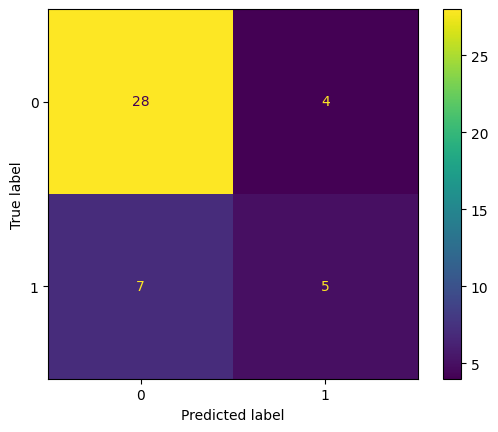

In [344]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, make_scorer
)

# === 1️⃣ Define data ===
X_train = X_ckd_rfe
y_train = y_ckd_smote

X_test = X_ckd_test[selected_features_ckd]
y_test = y_ckd_test

# === 2️⃣ Define Random Forest ===
rf_model = RandomForestClassifier(random_state=42)

# === 3️⃣ Parameter grid ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

# === 4️⃣ Scorer: F1 for CKD (class 1) ===
f1_scorer = make_scorer(f1_score, pos_label=1)

# === 5️⃣ Grid Search ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    rf_model,
    param_grid,
    cv=cv,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

# === 6️⃣ Evaluate ===
y_pred = grid.predict(X_test)

print("Best Parameters:", grid.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("F1 Score (CKD = class 1):", f1_score(y_test, y_pred, pos_label=1))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64        23
         1.0       0.61      0.67      0.64        21

    accuracy                           0.64        44
   macro avg       0.64      0.64      0.64        44
weighted avg       0.64      0.64      0.64        44



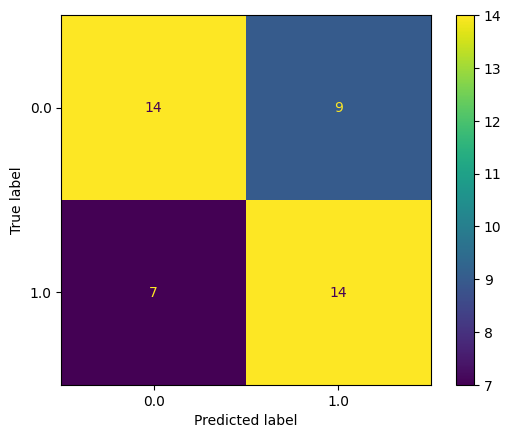

In [345]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.metrics import make_scorer

# Step 1: Define model
rf_model_remission = RandomForestClassifier(random_state=42)

# Step 2: Parameter grid
param_grid_remission = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Step 3: Use recall scorer for class 0 (delayed remission)
recall_class_0 = make_scorer(recall_score, pos_label=0)

# Step 4: Grid Search
grid_remission = GridSearchCV(
    rf_model_remission,
    param_grid=param_grid_remission,
    scoring=recall_class_0,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Step 5: Fit model using RFE-selected training data
grid_remission.fit(X_remission_rfe, y_remission)

X_remission_test_rfe = X_remission_test[X_remission_rfe.columns]

# Step 6: Evaluate on test set
y_remission_pred_rf = grid_remission.predict(X_remission_test_rfe)

print("Best Parameters:", grid_remission.best_params_)
print("\nClassification Report:")
print(classification_report(y_remission_test, y_remission_pred_rf))

# Optional: Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_remission_test, y_remission_pred_rf)

**ii) MLP**

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.83      0.42      0.56        12

    accuracy                           0.82        44
   macro avg       0.82      0.69      0.72        44
weighted avg       0.82      0.82      0.80        44

F2 Score (CKD = class 1): 0.46296296296296297


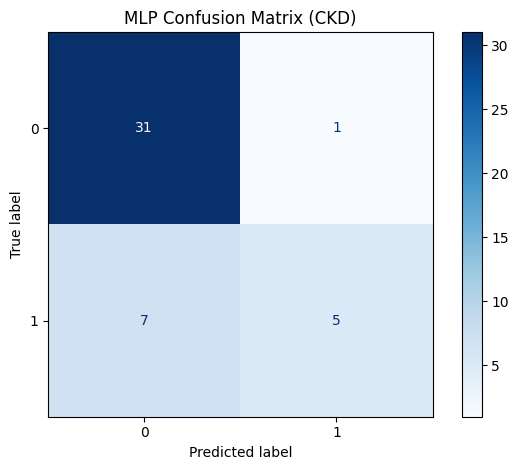

In [346]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    fbeta_score, make_scorer, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

X_test = X_ckd_test[selected_features_ckd]

# === 1. Define MLP & Hyperparameter Grid ===
mlp = MLPClassifier(max_iter=500, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# === 2. F1 scorer: balance recall and precision ===
f1_score_class_1 = make_scorer(f1_score, pos_label=1)

# === 3. Cross-validation and Grid Search ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring=f1_score_class_1,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_ckd_rfe, y_ckd_smote)

# === 4. Evaluation on Test Set ===
best_mlp = grid_search.best_estimator_

y_pred = best_mlp.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_ckd_test, y_pred))
print("F2 Score (CKD = class 1):", fbeta_score(y_ckd_test, y_pred, beta=2))

# === 5. Confusion Matrix Plot ===
cm = confusion_matrix(y_ckd_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_mlp.classes_)
disp.plot(cmap="Blues")
plt.title("MLP Confusion Matrix (CKD)")
plt.grid(False)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.57      0.59        23
         1.0       0.57      0.62      0.59        21

    accuracy                           0.59        44
   macro avg       0.59      0.59      0.59        44
weighted avg       0.59      0.59      0.59        44

Recall Score (Delayed Remission = class 0): 0.5652173913043478


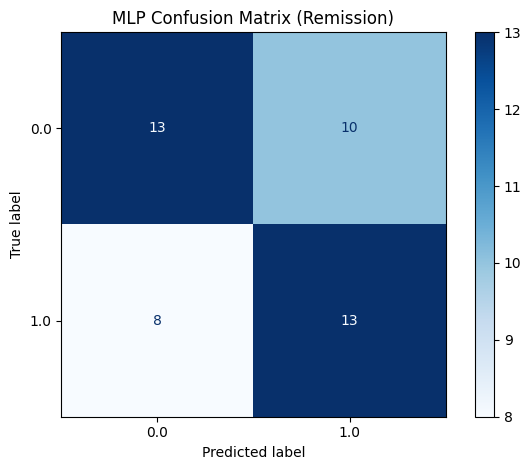

In [347]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    recall_score, make_scorer, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# === 1. Align test set using RFE-selected columns ===
X_test = X_remission_test[X_remission_rfe.columns]

# === 2. Define MLP & Hyperparameter Grid ===
mlp = MLPClassifier(max_iter=500, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# === 3. Use recall score (pos_label = 0 = delayed remission) ===
scorer = make_scorer(recall_score, pos_label=0)

# === 4. Cross-validation and Grid Search ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_remission_rfe, y_remission)

# === 5. Evaluate on Test Set ===
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_remission_test, y_pred))
print("Recall Score (Delayed Remission = class 0):", recall_score(y_remission_test, y_pred, pos_label=0))

# === 6. Confusion Matrix ===
cm = confusion_matrix(y_remission_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_mlp.classes_)
disp.plot(cmap="Blues")
plt.title("MLP Confusion Matrix (Remission)")
plt.grid(False)
plt.tight_layout()
plt.show()

**iii) SVM**

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Hyperparameters: {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.75      0.79        32
           1       0.47      0.58      0.52        12

    accuracy                           0.70        44
   macro avg       0.65      0.67      0.65        44
weighted avg       0.73      0.70      0.71        44



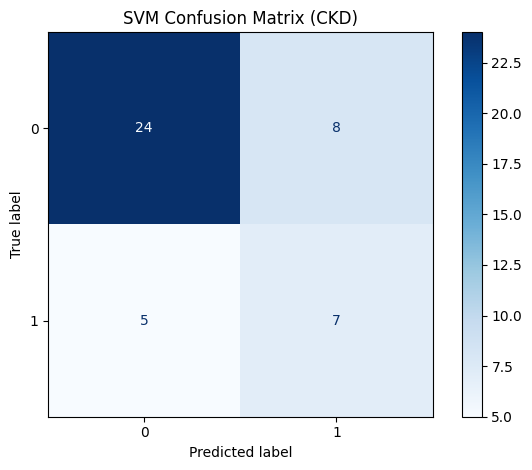

In [348]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    fbeta_score, make_scorer, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# === 1. Align test set ===
X_test = X_ckd_test[selected_features_ckd]

# === 2. Define SVM + Grid ===
svm = SVC()

param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}


# === 3. Scorer for CKD (recall class 1) ===
scorer = make_scorer(recall_score, pos_label=1)

# === 4. Grid Search ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_ckd_rfe, y_ckd_smote)

# === 5. Evaluation ===
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_ckd_test, y_pred))

# === 6. Confusion Matrix ===
cm = confusion_matrix(y_ckd_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap="Blues")
plt.title("SVM Confusion Matrix (CKD)")
plt.grid(False)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Hyperparameters: {'C': 1, 'kernel': 'linear'}

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.70      0.68        23
         1.0       0.65      0.62      0.63        21

    accuracy                           0.66        44
   macro avg       0.66      0.66      0.66        44
weighted avg       0.66      0.66      0.66        44

Recall Score (Delayed Remission = class 0): 0.6956521739130435


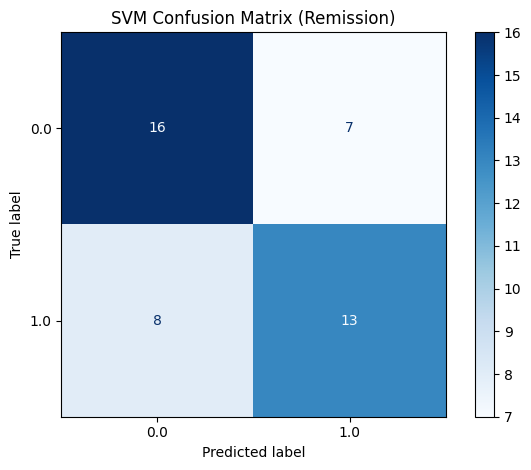

In [349]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    recall_score, make_scorer, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# === 1. Align test set ===
X_test = X_remission_test[X_remission_rfe.columns]

# === 2. Define SVM + Grid ===
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],

}

# === 3. Scorer for delayed remission (class 0) ===
scorer = make_scorer(recall_score, pos_label=0)

# === 4. Grid Search ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_remission_rfe, y_remission)

# === 5. Evaluation ===
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_remission_test, y_pred))
print("Recall Score (Delayed Remission = class 0):", recall_score(y_remission_test, y_pred, pos_label=0))

# === 6. Confusion Matrix ===
cm = confusion_matrix(y_remission_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap="Blues")
plt.title("SVM Confusion Matrix (Remission)")
plt.grid(False)
plt.tight_layout()
plt.show()

           Model     Target  Recall
0       CatBoost        CKD    0.75
1            SVM        CKD    0.58
2  Random Forest        CKD    0.42
3            MLP        CKD    0.42
4            SVM  Remission    0.70
5       CatBoost  Remission    0.65
6            MLP  Remission    0.62
7  Random Forest  Remission    0.61


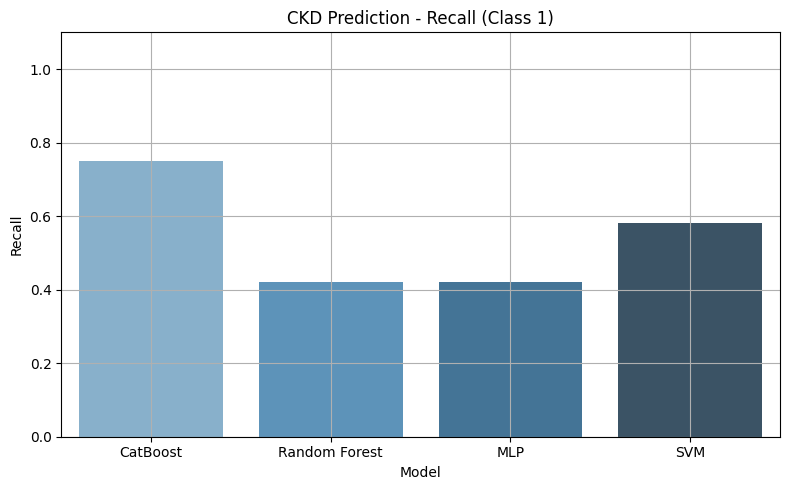

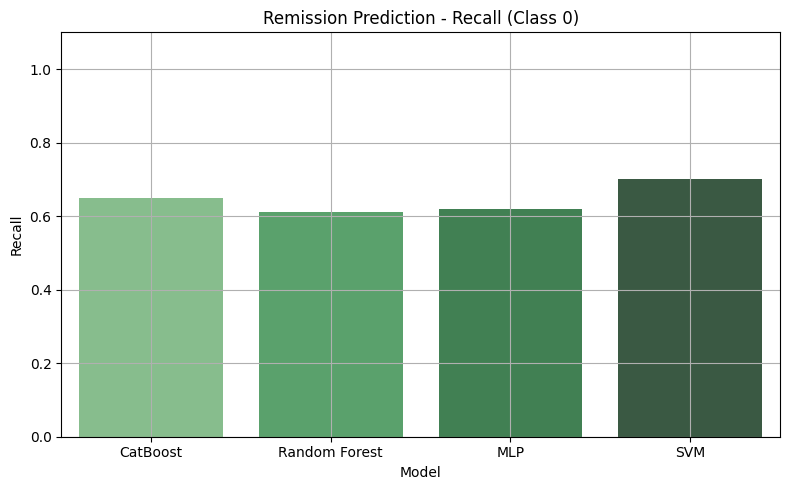

In [350]:
import pandas as pd
import seaborn as sns

model_results = [
    {'Model': 'CatBoost', 'Target': 'CKD', 'Recall': 0.75},
    {'Model': 'Random Forest', 'Target': 'CKD', 'Recall': 0.42},
    {'Model': 'MLP', 'Target': 'CKD', 'Recall': 0.42},
    {'Model': 'SVM', 'Target': 'CKD', 'Recall': 0.58 },

    {'Model': 'CatBoost', 'Target': 'Remission', 'Recall': 0.65},
    {'Model': 'Random Forest', 'Target': 'Remission', 'Recall': 0.61},
    {'Model': 'MLP', 'Target': 'Remission', 'Recall': 0.62 },
    {'Model': 'SVM', 'Target': 'Remission', 'Recall': 0.70 },
]

df_summary = pd.DataFrame(model_results)
df_summary = df_summary.sort_values(by=['Target', 'Recall'], ascending=[True, False]).reset_index(drop=True)

# Display
print(df_summary)

df_summary = pd.DataFrame(model_results)


# === Plot for CKD ===
plt.figure(figsize=(8, 5))
sns.barplot(data=df_summary[df_summary["Target"] == "CKD"], x="Model", y="Recall", palette="Blues_d")
plt.title("CKD Prediction - Recall (Class 1)")
plt.ylim(0, 1.1)
plt.ylabel("Recall")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot for Remission ===
plt.figure(figsize=(8, 5))
sns.barplot(data=df_summary[df_summary["Target"] == "Remission"], x="Model", y="Recall", palette="Greens_d")
plt.title("Remission Prediction - Recall (Class 0)")
plt.ylim(0, 1.1)
plt.ylabel("Recall")
plt.grid(True)
plt.tight_layout()
plt.show()

# SHAP

CKD

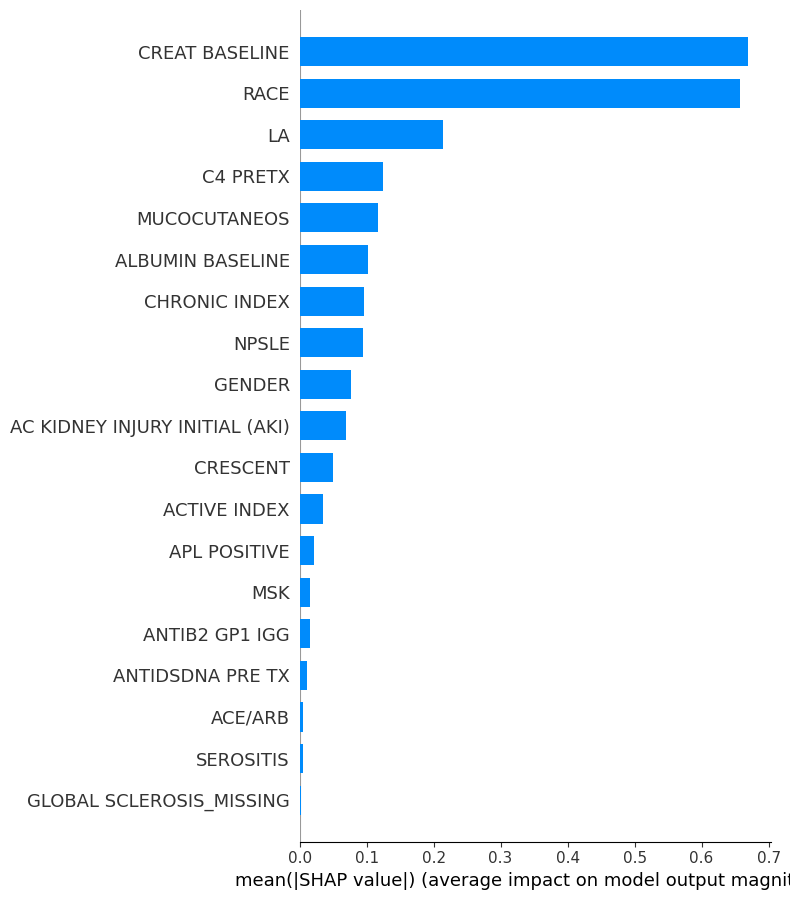

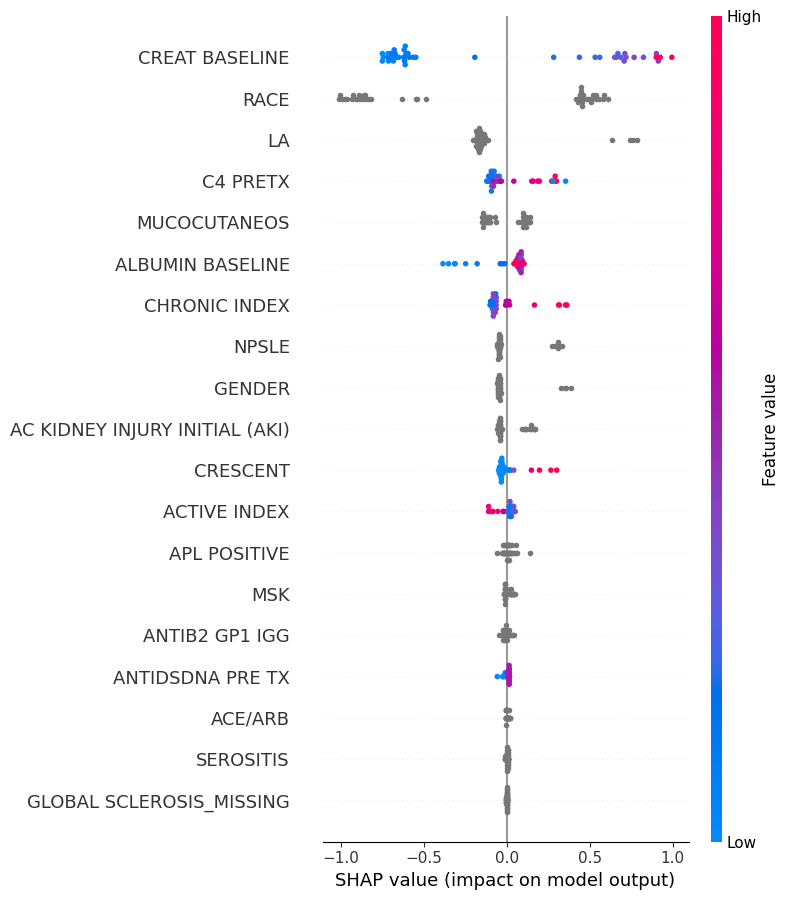

In [351]:
import shap

# === Initialize SHAP explainer on best CKD model ===
explainer = shap.TreeExplainer(best_cb)

# === Compute SHAP values on the RFE-subsetted test set ===
shap_values = explainer.shap_values(X_cb_ckd_test_rfe)

# === Handle binary classification case ===
if isinstance(shap_values, list):
    shap_vals_to_plot = shap_values[1]  # Class 1 = CKD
else:
    shap_vals_to_plot = shap_values

# === Plot SHAP summary ===
shap.summary_plot(shap_vals_to_plot, X_cb_ckd_test_rfe, plot_type="bar")
shap.summary_plot(shap_vals_to_plot, X_cb_ckd_test_rfe)


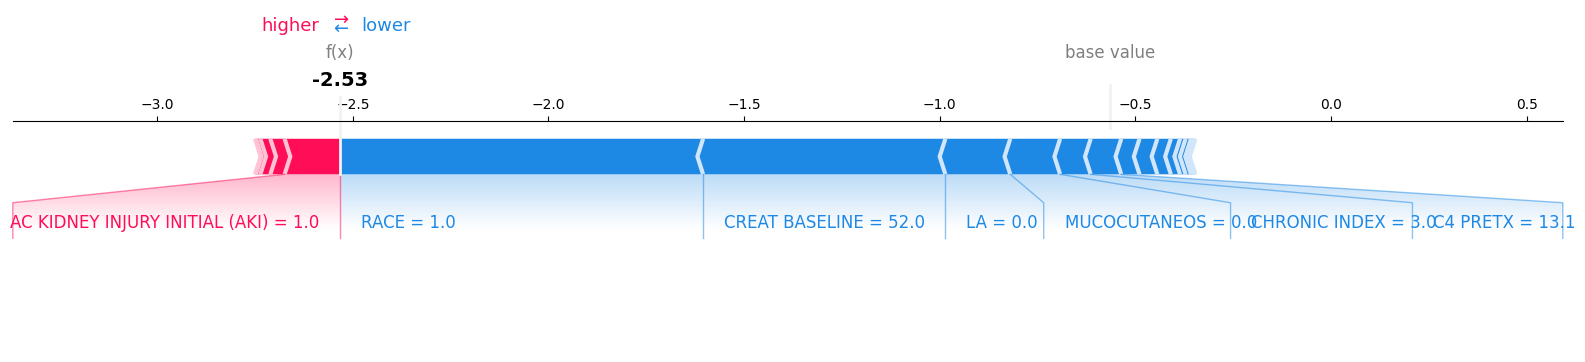

In [352]:
# Pick a specific patient index (e.g., the first patient in test set)
i = 0

# Force plot (CKD: class 1)
shap.force_plot(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_vals_to_plot[i],
    X_cb_ckd_test_rfe.iloc[i],
    matplotlib=True
)


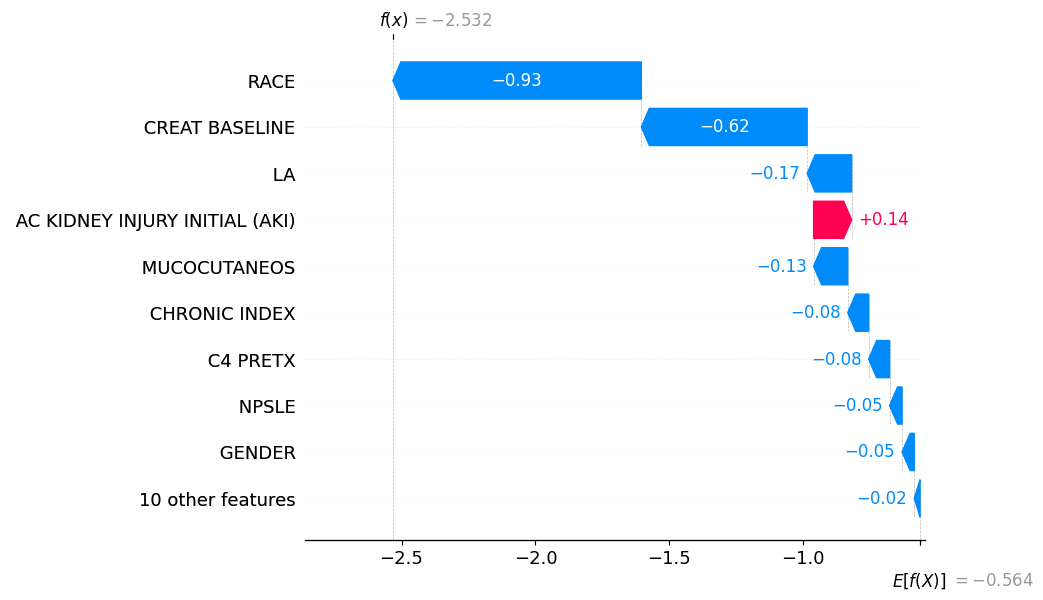

In [353]:
import shap

# 1. Pick a specific test patient
i = 0

# 2. Use SHAP TreeExplainer for CatBoost
explainer_ckd = shap.TreeExplainer(best_cb)

# 3. Calculate SHAP values
shap_values_ckd = explainer_ckd.shap_values(X_cb_ckd_test_rfe)

# 4. Select SHAP values for class 1 (CKD positive)
shap_vals_ckd_plot = shap_values_ckd[1] if isinstance(shap_values_ckd, list) else shap_values_ckd

# 5. Plot: SHAP Waterfall for one patient
shap.plots._waterfall.waterfall_legacy(
    explainer_ckd.expected_value[1] if isinstance(explainer_ckd.expected_value, list) else explainer_ckd.expected_value,
    shap_vals_ckd_plot[i],
    X_cb_ckd_test_rfe.iloc[i]
)


In [354]:
# Text-based summary for top 3 features
contribs_ckd = sorted(zip(X_cb_ckd_test.columns, shap_vals_to_plot[i]), key=lambda x: abs(x[1]), reverse=True)

print("Top 3 Factors Influencing This CKD Prediction:")
for feat, val in contribs_ckd[:3]:
    direction = "↑" if val > 0 else "↓"
    print(f"- {feat} ({direction})")


Top 3 Factors Influencing This CKD Prediction:
- ANA (↓)
- HEMATO (↓)
- C3 PRE TX (↓)


Delayed Remission

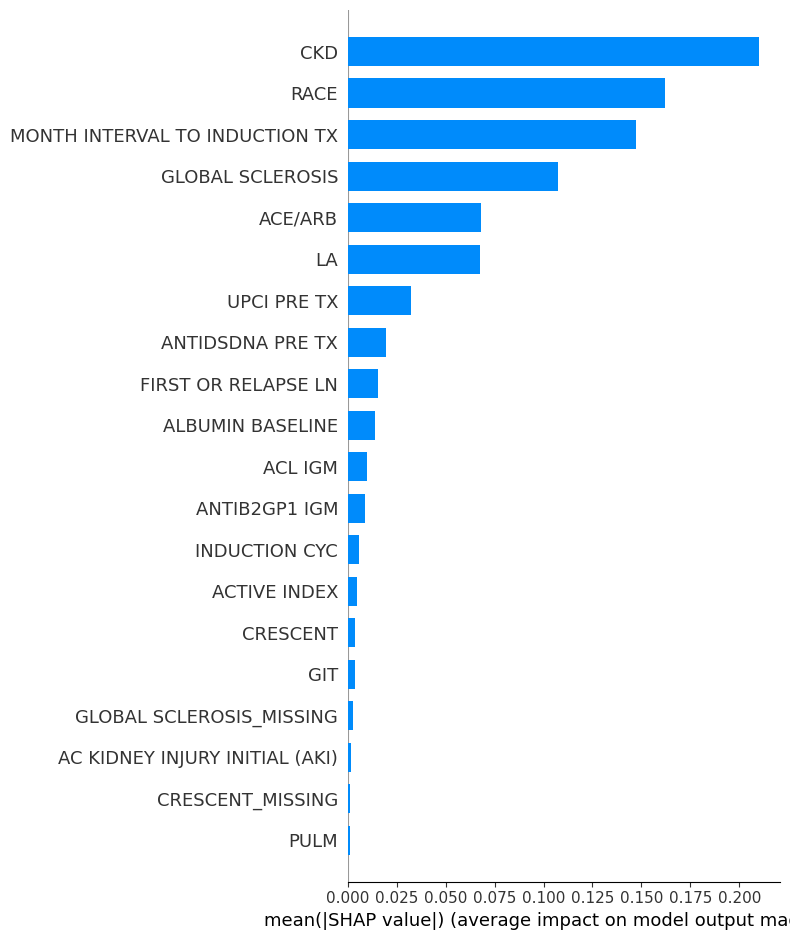

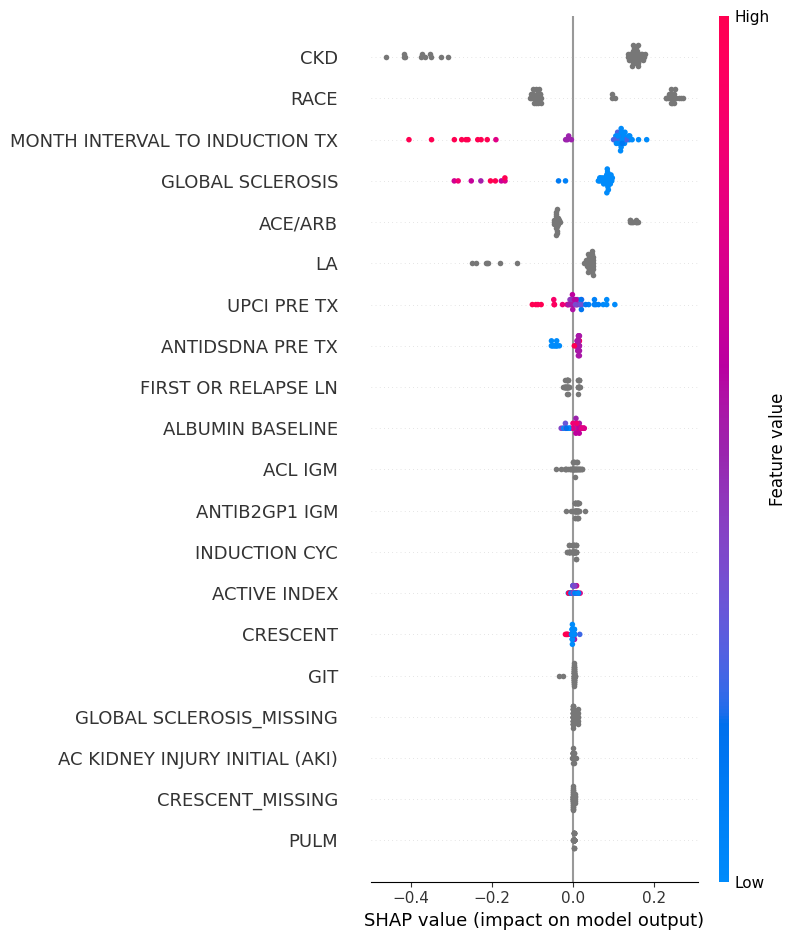

In [355]:
import shap

# Use the test set that was used for model.predict()
X_shap = X_cb_remission_test_rfe  # make sure this is numeric, no string/categorical columns

# 1. SHAP Explainer
explainer_remission = shap.TreeExplainer(best_remission_model)

# 2. SHAP values
shap_values_remission = explainer_remission.shap_values(X_shap)

# 3. Handle binary classification
if isinstance(shap_values_remission, list):
    shap_vals_to_plot = shap_values_remission[0]  # class 0 = Delayed remission
else:
    shap_vals_to_plot = shap_values_remission

# 4. SHAP Summary Plots
shap.summary_plot(shap_vals_to_plot, X_shap, plot_type="bar")
shap.summary_plot(shap_vals_to_plot, X_shap)


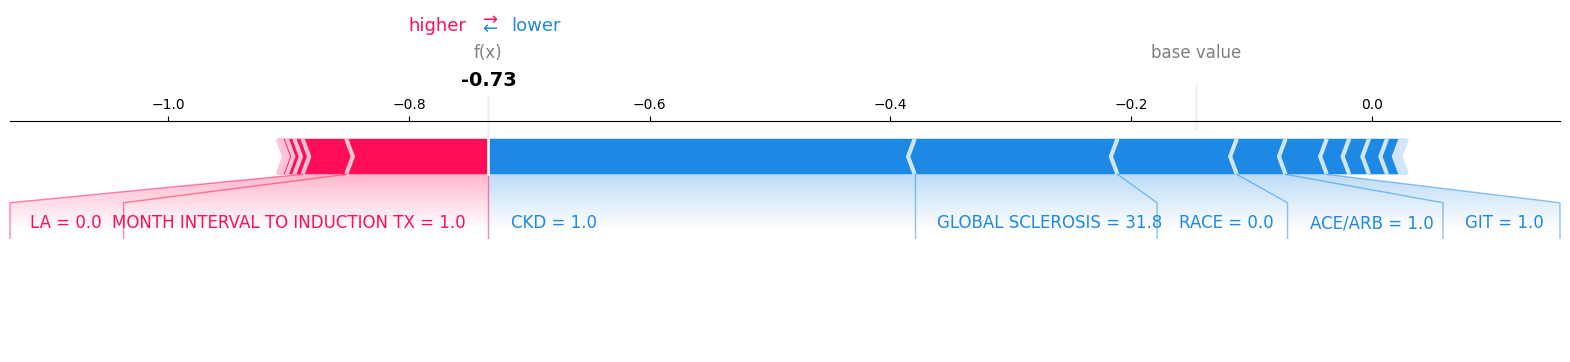

In [356]:
# Force plot (class 0: delayed remission)
# Select specific patient index
i = 1
shap.force_plot(
    explainer_remission.expected_value[0] if isinstance(explainer_remission.expected_value, list) else explainer_remission.expected_value,
    shap_vals_to_plot[i],
    X_cb_remission_test_rfe.iloc[i],
    matplotlib=True
)

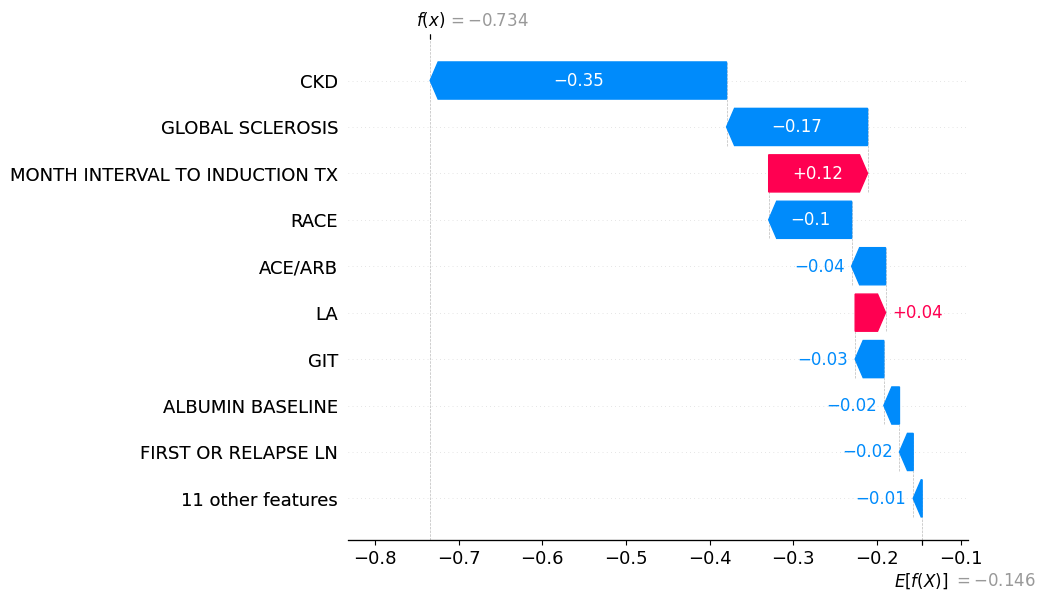

In [357]:
# Waterfall plot
shap.plots._waterfall.waterfall_legacy(
    explainer_remission.expected_value[0] if isinstance(explainer_remission.expected_value, list) else explainer_remission.expected_value,
    shap_vals_to_plot[i],
    feature_names=X_cb_remission_test_rfe.columns.tolist()
)


In [358]:
row0 = X_cb_remission_test_rfe.iloc[[0]]
pred = best_remission_model.predict(row0)
print("Prediction (Remission - row 0):", pred[0])


Prediction (Remission - row 0): 1


In [359]:
# Print top 3 contributing features for this patient
contribs = sorted(zip(X_cb_remission_test.columns, shap_vals_to_plot[i]), key=lambda x: abs(x[1]), reverse=True)

print("Top 3 Factors Influencing This Prediction:")
for feat, val in contribs[:3]:
    direction = "↑" if val > 0 else "↓"
    print(f"- {feat} ({direction})")


Top 3 Factors Influencing This Prediction:
- ALBUMIN BASELINE (↓)
- MUCOCUTANEOS (↓)
- NPSLE (↑)


# Export

CKD

In [360]:
import joblib
from google.colab import files

# Save the tuned CKD CatBoost model
joblib.dump(best_cb, "catboost_ckd_model.pkl")

# Trigger download to your PC
files.download("catboost_ckd_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Remission

In [361]:
import joblib
from google.colab import files

# Save the tuned CatBoost remission model
joblib.dump(best_remission_model, "catboost_remission_model.pkl")

# Trigger download to your PC
files.download("catboost_remission_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>